## Single parameter variation for MW-M31 Merger

This program is the very first that I wrote in my first week of internship in March. It is quite long to run, and contain a lot of different variables, with names that can be confusing. It is only used for varying parameter one by one (see part 1.2 in the report). Some units have to be fixed after in order to get the right units on the axis, using astropy.units and a lot of different steps. This problem has been fixed in the next programs. It's only a preliminary work. As it has only been used for one week, I have not spend time to rewrite it more efficiently. 

It models the galaxies as point masses. The evolution of positions and velocities with time is calculated by a Leapfrog integration method (see Philip Mocz on github). The uncertainties are taken into account by looping over a random distribution function for the initial values. We create Monte Carlo samples and begin by determining the impact parameter value by randomly sampling values from a normal distribution, only for one parameter at each time. Then, we store our different values of $r$, $b$, and $t_b$ in arrays, to study the consequences of the uncertainties on the impact parameter ($b$) and the time when it occurs ($t_b$).

## Imports

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

## General parameters / Initial conditions values

In [43]:
""" N-body simulation  """

# Simulation parameters
N         = 2    # Number of particles
t         = 0      # current time of the simulation
tEnd      = 8000*u.Myr  # time at which simulation ends
tEnd      = tEnd.si.value
dt        = 2*u.Myr  # timestep
dt        = dt.si.value
softening = 17*u.kpc # Hernquist softening length
softening = softening.si.value   
G         = 6.67430*10**(-11)*u.N*u.m**2*u.kg**(-2)   # Newton's Gravitational Constant
G         = G.si.value


# Here we give the values of known parameters and their uncertainty

#Known distance between the Milky Way and Andromeda

r=765*u.kpc
r=r.si.value #Exctracting numerical value

dr=11*u.kpc #Uncertainty on r
dr=dr.si.value
var_r=np.random.normal(r,dr,500) #Normal distribution for r, with 500 different values (see histograms)

#Mass of the Milky Way

MW=0.9*10**12*u.Msun 
MW=MW.si.value

dMW=0.4*10**12*u.Msun
dMW=dMW.si.value
var_MW=np.random.normal(MW,dMW,500)

#Mass of Andromeda
M31=2.3*10**12*u.Msun
M31=M31.si.value

dM31=1.0*10**12*u.Msun
dM31=dM31.si.value
var_M31= np.random.normal(M31,dM31,500)

#Radial velocity of Andromeda towards the Milky Way

vr=-109.3*u.km/u.s
vr=vr.si.value
dvr=4.4*u.km/u.s
dvr=dvr.si.value
var_vr=np.random.normal(vr,dvr,500)


#Transverse velocity of Andromeda towards the Milky Way

vt=57*u.km/u.s
vt=vt.si.value
dvt=35*u.km/u.s
dvt=dvt.si.value
var_vt=np.random.normal(vt,dvt,500)


### Cinematics functions :

In [44]:
def getAcc( pos, mass, G, softening ):
    """
    Calculate the acceleration on each particle due to Newton's Law 
    pos  is an N x 3 matrix of positions
    mass is an N x 1 vector of masses
    G is Newton's Gravitational constant
    softening is the softening length
    a is N x 3 matrix of accelerations
    """
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass

    # pack together the acceleration components
    a = np.hstack((ax,ay,az))

    return a

### b calculation function

In [45]:
def calculate_b(k,ini,t) :

    blist=[]
    tlist=[]
    
    for j in range (len(var)): 

        ini[k]=var[j] #Initial values are associated with the chosen varying parameter

        mass = np.array([[ini[12]],[ini[13]]]) #Stores the initial masses values
        pos  = np.array([[ini[0],ini[2],ini[4]],[ini[1],ini[3],ini[5]]]) #Stores the initial positions values
        vel  = np.array([[ini[6],ini[8],ini[10]],[ini[7],ini[9],ini[11]]]) #Stores the initial velocities values

        vel= vel-np.mean(mass * vel,0) / np.mean(mass) #Placement in the center of masses
        

        # calculate initial gravitational accelerations
        acc = getAcc( pos, mass, G, softening )

        
        # number of timesteps
        Nt = int(np.ceil( (tEnd) /dt))

        # save energies, particle orbits for plotting trails
        pos_save = np.zeros((N,3,Nt+1))
        pos_save[:,:,0] = pos
        vel_save = np.zeros((N,3,Nt+1))
        vel_save[:,:,0] = vel

        t_all = np.arange(Nt+1)*dt


        # Simulation Main Loop : Leapfrog integrator
        for i in range(Nt):
            # (1/2) kick
            vel += acc * dt /2.0

            # drift
            pos += vel * dt

            # update accelerations
            acc = getAcc( pos, mass, G, softening )

            # (1/2) kick
            vel += acc * dt/2.0

            # update time
            t += dt
            
            pos_save[:,:,i+1] = pos
            vel_save[:,:,i+1] = vel
         

       
        x1=pos_save[0,0,:]
        x2=pos_save[1,0,:]
        y1=pos_save[0,1,:]
        y2=pos_save[1,1,:]

        r=np.sqrt((x2-x1)**2+(y2-y1)**2) #Calculate the new distance between the galaxies
        b=min(r) #b is the first local minimum of r, also called impact parameter
        t_b=np.argmin(r)*dt #t_b is the time when b occurs

        blist.append(b)
        tlist.append(t_b)
    barray=np.array(blist)
    tarray=np.array(tlist)
    return barray, tarray 


### Chosen Initial conditions

In [46]:
#Chosen initial conditions

x1=0      #0
x2=r      #1
y1=0      #2
y2=0      #3
z1=0      #4
z2=0      #5

vx1=0     #6
vx2=vr    #7
vy1=0     #8
vy2=vt    #9
vz1=0     #10
vz2=0     #11

M1=MW     #12
M2=M31    #13

#Vectors containing the values of initial conditions
ini_pos=np.array([x1,x2,y1,y2,z1,z2])
ini_vel=np.array([vx1,vx2,vy1,vy2,vz1,vz2])
ini_mass=np.array([M1,M2])
ini=np.concatenate((ini_pos,ini_vel, ini_mass))



### Varying parameters

In [47]:
var=var_MW #varying parameter
var_bMW, var_tMW=calculate_b(12,ini,t) #impact on b and t_b

In [48]:
var=var_M31
var_bM31, var_tM31=calculate_b(13,ini,t)

In [49]:
var=var_r 
var_br, var_tr = calculate_b(1,ini,t) 

In [50]:
var=var_vr
var_bvr, var_tvr= calculate_b(7,ini,t)

In [51]:
var=var_vt
var_bvt, var_tvt =calculate_b(9,ini,t)

In [52]:
def print_variable(variable):
    variable_name = [name for name, value in globals().items() if value is variable][0]
    print(f"Variable: {variable_name}")


def statistics(name) :
    print('-------------------------------------------------------------------------------------------')
    print_variable(name)
    print('mean=', np.mean(name))
    print('median=',np.median(name))
    print('standard deviation=',np.std(name))
    print('-1 sigma=',np.median(name) - np.percentile(name, 15.8))
    print('1 sigma=', np.percentile(name, 84.5) - np.median(name))

### Plotting variation impact 

In [53]:
#fixing units

a=1*u.kpc
a=a.si.value
m=1*u.Msun*1e12
m=m.si.value
p=1*u.Myr
p=p.si.value

var_br=var_br/a
var_bvr=var_bvr/a
var_bvt=var_bvt/a
var_bMW=var_bMW/a
var_bM31=var_bM31/a

var_r=var_r/a
var_vr=var_vr/1000
var_vt=var_vt/1000
var_MW=var_MW/m
var_M31=var_M31/m


In [54]:
var_tr=var_tr/p
var_tvr=var_tvr/p
var_tvt=var_tvt/p
var_tMW=var_tMW/p
var_tM31=var_tM31/p

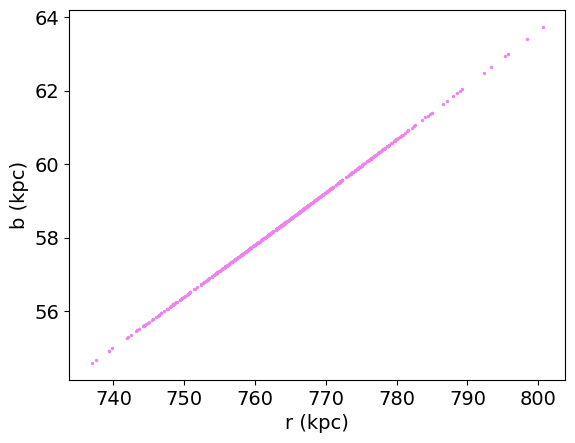

In [55]:
plt.rcParams.update({'font.size':14})
plt.xlabel('r (kpc)')
plt.ylabel('b (kpc)')

plt.scatter(var_r, var_br, s=2, color='violet')

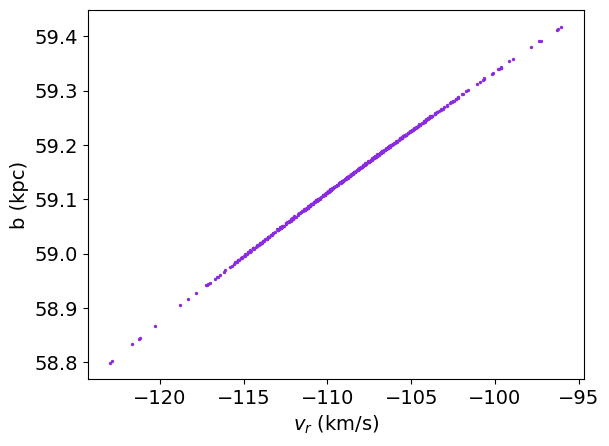

In [56]:
plt.rcParams.update({'font.size':14})

plt.xlabel('$v_r$ (km/s)')
plt.ylabel('b (kpc)')


plt.scatter(var_vr, var_bvr, s=2, color='blueviolet')

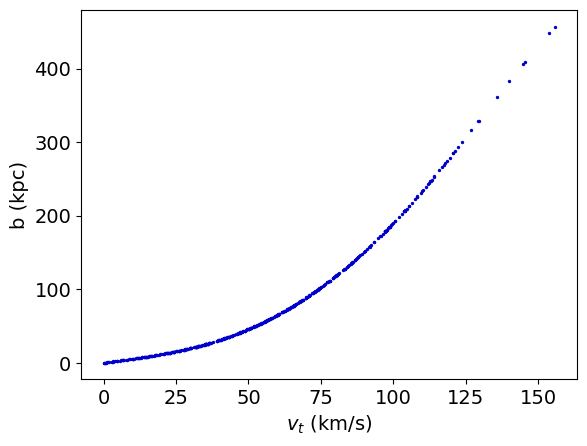

In [57]:
plt.rcParams.update({'font.size':14})
plt.xlabel('$v_t$ (km/s)')
plt.ylabel('b (kpc)')

plt.scatter(np.abs(var_vt), var_bvt, s=2, color='mediumblue')


<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
C:\Users\jehan\AppData\Local\Temp\ipykernel_4484\3809482278.py:2: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$m_{MW}$  ($10^{12} M_{\odot}$)')


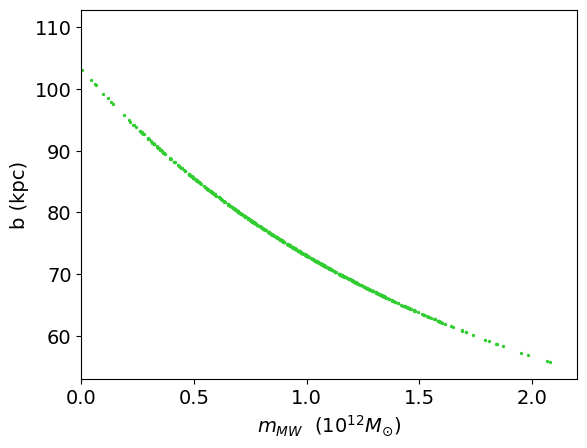

In [58]:
plt.rcParams.update({'font.size':14})
plt.xlabel('$m_{MW}$  ($10^{12} M_{\odot}$)')
plt.ylabel('b (kpc)')
plt.xlim(0,2.2)




plt.scatter(var_MW, var_bMW, s=2, color='limegreen')


<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
C:\Users\jehan\AppData\Local\Temp\ipykernel_4484\1643141905.py:2: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$m_{M31}$  ($10^{12} M_{\odot}$)')


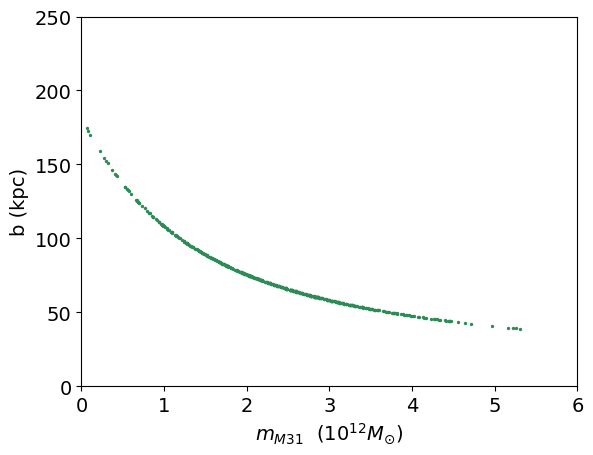

In [61]:
plt.rcParams.update({'font.size':14})
plt.xlabel('$m_{M31}$  ($10^{12} M_{\odot}$)')
plt.ylabel('b (kpc)')
plt.xlim(0,6)
plt.ylim(0,250)


plt.scatter(var_M31, var_bM31, s=2, color='seagreen')


<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:29: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:29: SyntaxWarning: invalid escape sequence '\o'
C:\Users\jehan\AppData\Local\Temp\ipykernel_4484\2869556327.py:23: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$m_{MW} (M_{\odot}$)')
C:\Users\jehan\AppData\Local\Temp\ipykernel_4484\2869556327.py:29: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$m_{M31} (M_{\odot}$)')


-------------------------------------------------------------------------------------------
Variable: var_br
mean= 58.44220053289788
median= 58.37745672967727
standard deviation= 1.5328690952480188
-1 sigma= 1.4354044336261609
1 sigma= 1.620182930232545
-------------------------------------------------------------------------------------------
Variable: var_bvr
mean= 59.14108880204184
median= 59.149077667305505
standard deviation= 0.09845402522158715
-1 sigma= 0.11148079213676709
1 sigma= 0.08614410733925126
-------------------------------------------------------------------------------------------
Variable: var_bvt
mean= 78.61673539845637
median= 52.22921627402525
standard deviation= 79.6999464074905
-1 sigma= 38.81282257557588
1 sigma= 100.03980846302375
-------------------------------------------------------------------------------------------
Variable: var_bMW
mean= 75.94674065918466
median= 74.50343763839754
standard deviation= 9.54106155021408
-1 sigma= 7.647448988202427
1 sigma=

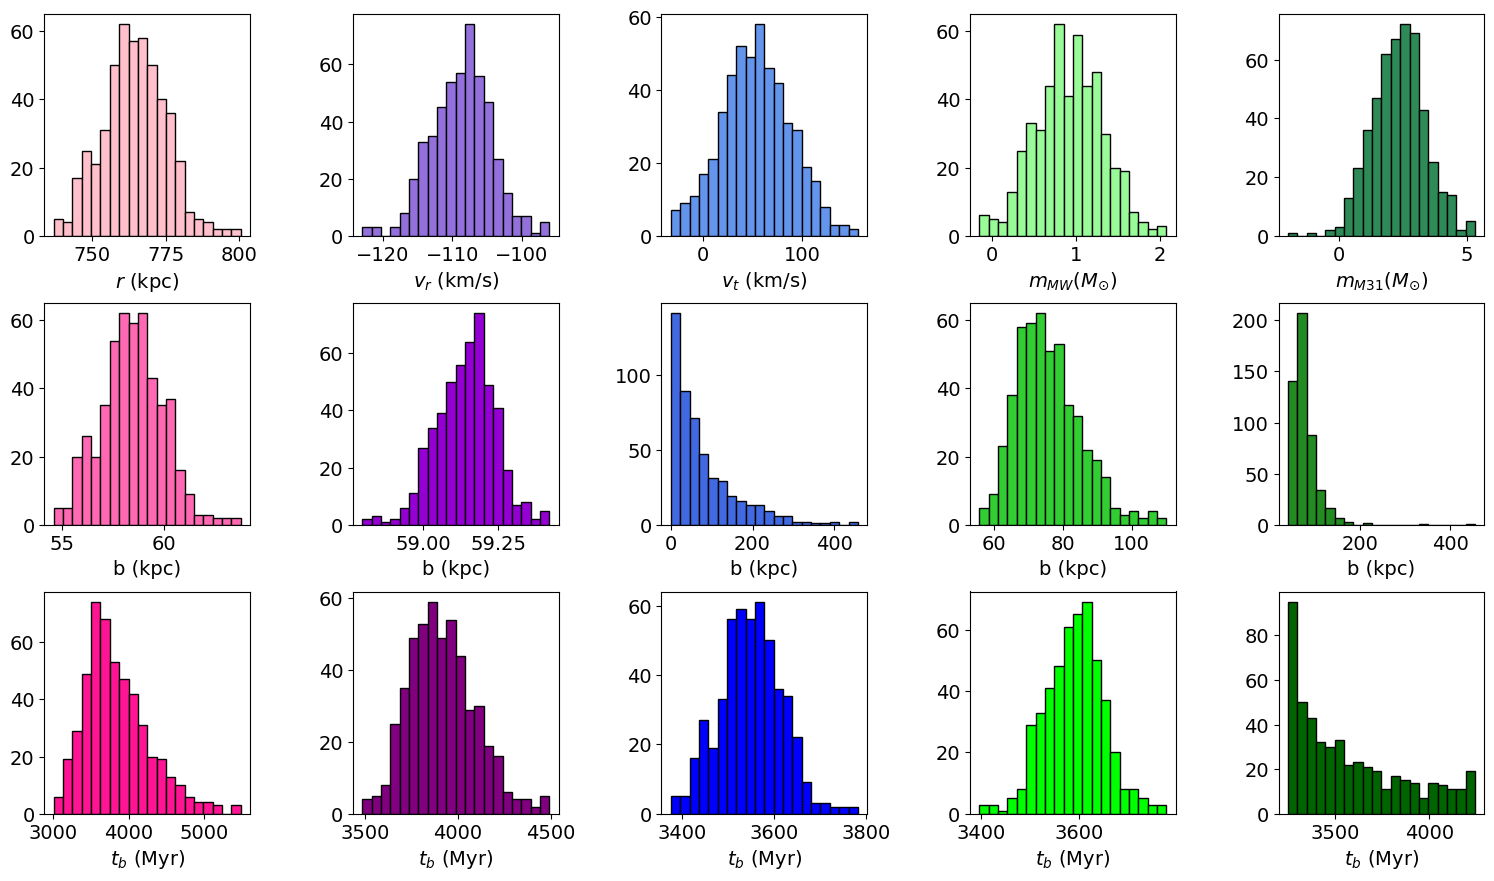

In [60]:
plt.figure(figsize = (8, 10)) 

plt.subplot(3,5,1)
plt.hist(var_r,color='pink',ec='black',bins=20)
plt.xlabel('$r$ (kpc)')



plt.subplot(3,5,2)
plt.hist(var_vr,color='mediumpurple',ec='black',bins=20)
plt.xlabel('$v_r$ (km/s)')



plt.subplot(3,5,3)
plt.hist(var_vt,color='cornflowerblue',ec='black',bins=20)
plt.xlabel('$v_t$ (km/s)')



plt.subplot(3,5,4)
plt.hist(var_MW, color='palegreen',ec='black',bins=20)
plt.xlabel('$m_{MW} (M_{\odot}$)')



plt.subplot(3,5,5)
plt.hist(var_M31,color='seagreen',ec='black',bins=20)
plt.xlabel('$m_{M31} (M_{\odot}$)')




#b variation
plt.subplot(3,5,6)


plt.xlabel('b (kpc)')
plt.hist(var_br,color='hotpink',ec='black',bins=20)

plt.subplot(3,5,7)

plt.xlabel('b (kpc)')
plt.hist(var_bvr,color='darkviolet',ec='black',bins=20)
plt.subplot(3,5,8)

plt.xlabel('b (kpc)')
plt.hist(var_bvt,color='royalblue',ec='black',bins=20)

plt.subplot(3,5,9)

plt.xlabel('b (kpc)')
plt.hist(var_bMW,color='limegreen',ec='black',bins=20)

plt.subplot(3,5,10)

plt.xlabel('b (kpc)')
plt.hist(var_bM31,color='forestgreen',ec='black',bins=20)


#t_variation

plt.subplot(3,5,11)
plt.xlabel('$t_b$ (Myr)')
plt.hist(var_tM31,color='deeppink',ec='black',bins=20)

plt.subplot(3,5,12)


plt.xlabel('$t_b$ (Myr)')
plt.hist(var_tMW,color='purple',ec='black',bins=20)

plt.subplot(3,5,13)


plt.xlabel('$t_b$ (Myr)')
plt.hist(var_tr,color='blue',ec='black',bins=20)

plt.subplot(3,5,14)


plt.xlabel('$t_b$ (Myr)')
plt.hist(var_tvr,color='lime',ec='black',bins=20)

plt.subplot(3,5,15)


plt.xlabel('$t_b$ (Myr)')
plt.hist(var_tvt,color='darkgreen',ec='black',bins=20)



plt.gcf().subplots_adjust(left = 0.2, bottom = 0.1, right = 2, top = 0.9, wspace = 0.5, hspace = 0.3)


statistics(var_br)
statistics(var_bvr)
statistics(var_bvt)
statistics(var_bMW)
statistics(var_bM31)

statistics(var_tr)
statistics(var_tvr)
statistics(var_tvt)
statistics(var_tMW)
statistics(var_tM31)





